In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. TFIDF

The output ['ab' 'abilities' 'ability' 'able' ...] highlights two major limitations of TF-IDF for this task:

Redundancy (Lack of Stemming/Lemmatization): Words like abilities, ability, and able are treated as completely different features. This dilutes the signal because the model doesn't understand they share the same root meaning.

Lack of Context: TF-IDF only counts words. It doesn't know that "Software Engineer" and "Application Developer" are nearly identical roles if they don't share the exact same keywords.

In [2]:
# 1. Load the dataset
df = pd.read_csv("Hackathon_Datasets_Refined_v5.csv")

# 2. Preprocessing: Combine relevant text columns into a single 'content' field
# We fill NaN values with empty strings to avoid errors
df['combined_text'] = (
    df['job_title'].fillna('') + ' ' +
    df['position_summary'].fillna('') + ' ' +
    df['responsibilities'].fillna('') + ' ' +
    df['qualifications'].fillna('')
)

# Function to clean text (lowercase, remove punctuation/numbers)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# Apply cleaning
df['clean_text'] = df['combined_text'].apply(clean_text)

# 3. Initialize TF-IDF Vectorizer
# - stop_words='english': Removes common words like 'the', 'and', 'is'
# - max_features=5000: Limits the vocabulary to the top 5,000 most frequent terms
# - min_df=5: Ignores terms that appear in fewer than 5 documents (removes rare typos/names)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=5)

# 4. Fit and Transform the text to create the numerical matrix
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

# Output the shape of the resulting matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"First 10 feature names: {vectorizer.get_feature_names_out()[:10]}")

TF-IDF Matrix Shape: (622, 4113)
First 10 feature names: ['ab' 'abilities' 'ability' 'able' 'abnormal' 'abreast' 'absa' 'absence'
 'absences' 'absolute']


# 2. Sentence Embedding

Capture Semantic Meaning: They understand that "managing a team" is similar to "supervising staff."

Handle Synonyms: They can group "HR Advisor" and "People Operations" together even if the words are different.

Reduce Dimensions: Instead of a sparse 4,000-column matrix (mostly zeros), you get a dense vector (e.g., 384 or 768 numbers) that is much better for clustering algorithms like K-Means or HDBSCAN.

In [ ]:
#install the necessary library:
!pip install sentence-transformers pandas

import pandas as pd
from sentence_transformers import SentenceTransformer

  Using cached pyyaml-6.0.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.4 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.3 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.2 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 19.5 MB/s  0:00:00
Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl (2.7 MB)
Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl (3.0 MB)
Using cached pyyaml-6.0.3-cp312-cp3

/opt/anaconda3/envs/nlp312_clean/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 1. Load the dataset
df = pd.read_csv("Hackathon_Datasets_Refined_v5.csv")

# 2. Combine text columns to create a full profile
# Combining Title + Summary + Responsibilities gives the model full context
df['combined_text'] = (
    df['job_title'].fillna('') + ' ' + 
    df['position_summary'].fillna('') + ' ' + 
    df['responsibilities'].fillna('') + ' ' + 
    df['qualifications'].fillna('')
)

# 3. Load a pre-trained model
# 'all-MiniLM-L6-v2' is a lightweight model optimized for clustering and semantic search
# highly efficient version of SBERT trained on over 1 billion sentence pairs.
model = SentenceTransformer('all-MiniLM-L6-v2')

# 4. Generate Embeddings
# This converts each job description into a 384-dimensional vector
embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)

# 5. Create a DataFrame of the embeddings (Optional, for visualization/saving)
embedding_df = pd.DataFrame(embeddings)

print(f"Embedding Matrix Shape: {embedding_df.shape}")
# Expected Output: (622, 384) -> 622 jobs, 384 semantic features per job

# Save embeddings to CSV for the next step (Clustering)
embedding_df.to_csv("job_embeddings.csv", index=False)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2231.57it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]

Embedding Matrix Shape: (622, 384)


# 3. K-Means Clustering

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

Running K-Means...


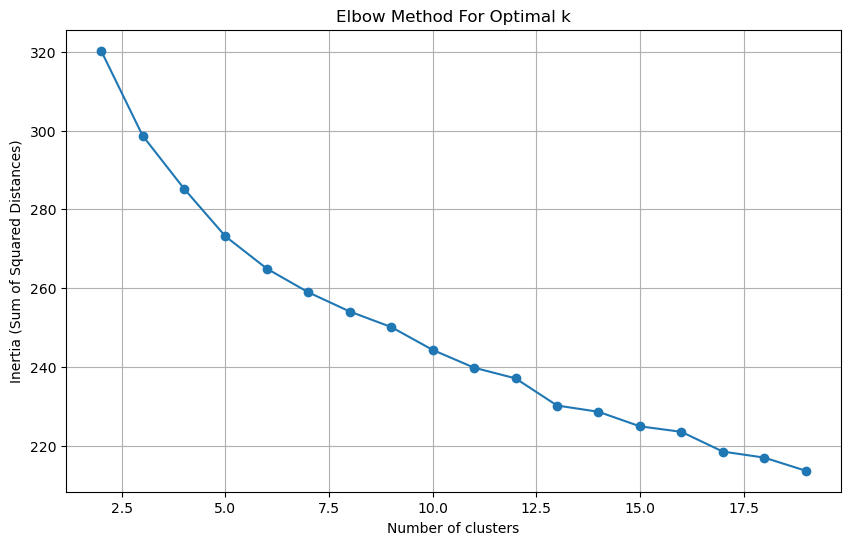

In [ ]:
# --- 1. LOAD DATA & DEFINE X ---
# We must load the embeddings file to get 'X'
embeddings_df = pd.read_csv("job_embeddings.csv")
X = embeddings_df.values  # This is the matrix of numbers the model needs

# Load original data to attach labels later
original_df = pd.read_csv("Hackathon_Datasets_Refined_v5.csv")

# ==========================================
# METHOD 1: K-MEANS CLUSTERING (Elbow Plot)
# ==========================================
inertia = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

# Apply Final K-Means Model (e.g., k=12 based on the plot)
optimal_k = 12
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)



# 4. Hierachical Clustering

Running Hierarchical Clustering...


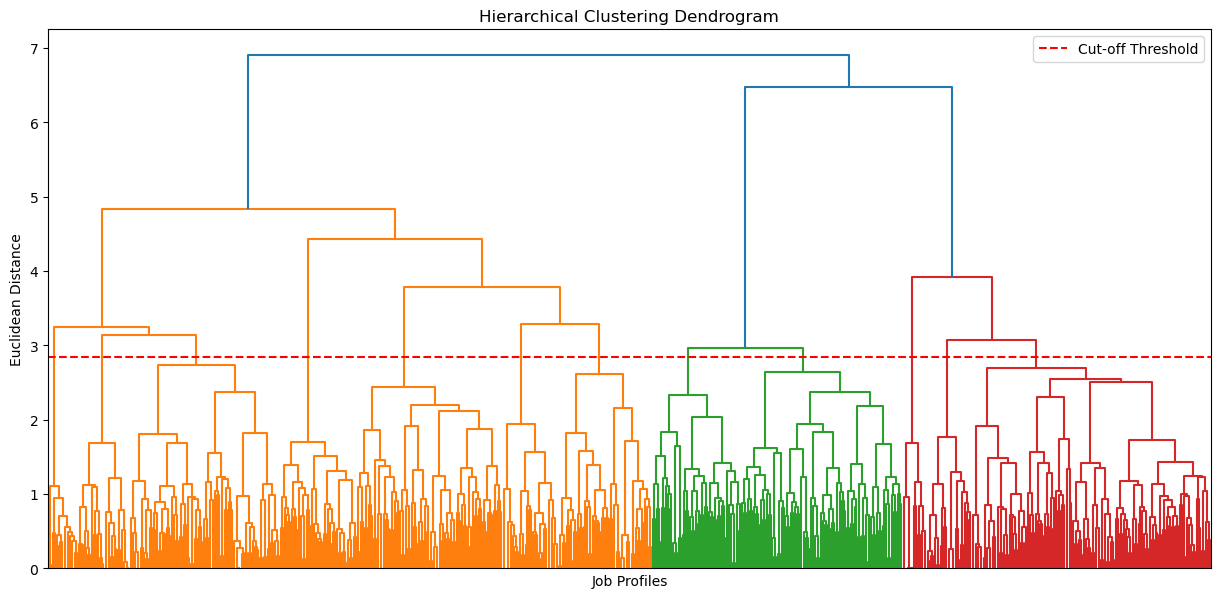

Hierarchical Clustering found 12 clusters at distance 2.85
Results saved to 'Hackathon_Clustered_Jobs.csv'


In [15]:
# ==========================================
# METHOD 2: HIERARCHICAL CLUSTERING
# ==========================================
print("Running Hierarchical Clustering...")

# 1. Compute the Linkage Matrix (The "Tree" structure)
# 'ward' minimizes variance within clusters, similar to K-Means
linkage_matrix = sch.linkage(X, method='ward')

# 2. Plot the Dendrogram
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True)

# 3. Add the Red Dashed Line (Threshold)
# This visual line helps you decide where to "cut" the tree
threshold_distance = 2.85  # You can adjust this value based on the plot height
plt.axhline(y=threshold_distance, color='r', linestyle='--', label='Cut-off Threshold')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Job Profiles')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.show()

# 4. Apply the Clustering based on the Threshold
# This automatically finds the number of clusters defined by your cut
hc = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=threshold_distance, 
    linkage='ward',
    metric='euclidean'
)
hc_labels = hc.fit_predict(X)

print(f"Hierarchical Clustering found {hc.n_clusters_} clusters at distance {threshold_distance}")

# ==========================================
# SAVE RESULTS
# ==========================================
original_df['KMeans_Cluster'] = kmeans_labels
original_df['Hierarchical_Cluster'] = hc_labels
original_df.to_csv("Hackathon_Clustered_Jobs.csv", index=False)
print("Results saved to 'Hackathon_Clustered_Jobs.csv'")